In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.nn.functional import pad
from safetensors.torch import load_file

C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [4]:
model_name = "zhihan1996/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, trust_remote_code=True)

C:\Users\Kevin\.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\7bce263b15377fc15361f52cfab88f8b586abda0\bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# This is too big to put on GitHub, but I finetuned using the instructions in the DNABERT-2 repo
# You will need to run the run_dnabert2.sh script in ./disabled_head_evals/, then point to the model weights within output/dnabert2,
# or move + rename like I have to make it a bit cleaner:
model_file_path = "./disabled_head_evals/output/DNABERT2_EMP_H3_model/model.safetensors"
loaded_state_dict = load_file(model_file_path, device=device)
model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

In [6]:
from lrp_engine import LRPEngine, checkpoint_hook

In [7]:
for layer_module in model.bert.encoder.layer:
    layer_module.attention.self.register_forward_hook(checkpoint_hook)

In [8]:
data_path = "../../external/GUE/EMP/H3/test.csv"
batch_size = 500
batch_start = 0
with open(data_path, "r") as fileIn:
    fileIn.readline()
    dna = []
    for _ in range(batch_start):
        fileIn.readline()
    for _ in range(batch_size):
        line = fileIn.readline()
        line = line.split(",")[0].strip()
        dna.append(line)

inputs = sorted([ tokenizer(x, return_tensors = 'pt')["input_ids"] for x in dna ], key=lambda t: t.shape[-1], reverse=True)


In [9]:
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_features=768, out_f

In [10]:
engine = LRPEngine()

In [11]:
outputs : torch.Tensor = model(inputs[0].to(device))

In [12]:
# Single example test
logits = outputs[0]
hidden_states = outputs.hidden_states
relevance_outputs = engine.run(hidden_states)


In [13]:
relevance_outputs1 = engine.run(hidden_states)

In [14]:
# Check results diff between 1st pass and 2nd pass on same input (should be ~0)
[
    ((c1 - c2)**2).sum()
    for (c1, c2) in zip(relevance_outputs[0] + relevance_outputs[1], relevance_outputs1[0] + relevance_outputs1[1])
]

[tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0')]

In [15]:
from util import accumulate_variable_matrix, visualize_attention_layer_relevance

In [16]:
agg_checkpoint_vals = None
from tqdm import tqdm
for i in tqdm(range(200)):
    inputs = tokenizer(dna[i], return_tensors = 'pt')["input_ids"]
    outputs : torch.Tensor = model(inputs.to(device))
    logits = outputs[0]
    hidden_states = outputs.hidden_states
    relevance_outputs = engine.run(hidden_states)

    checkpoint_vals = relevance_outputs[0]
    if agg_checkpoint_vals is None:
        agg_checkpoint_vals = checkpoint_vals
    else:
        for j in range(len(agg_checkpoint_vals)):
            accumulate_variable_matrix(agg_checkpoint_vals[j], checkpoint_vals[j])
            # agg_checkpoint_vals[j] += checkpoint_vals[j]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.83it/s]


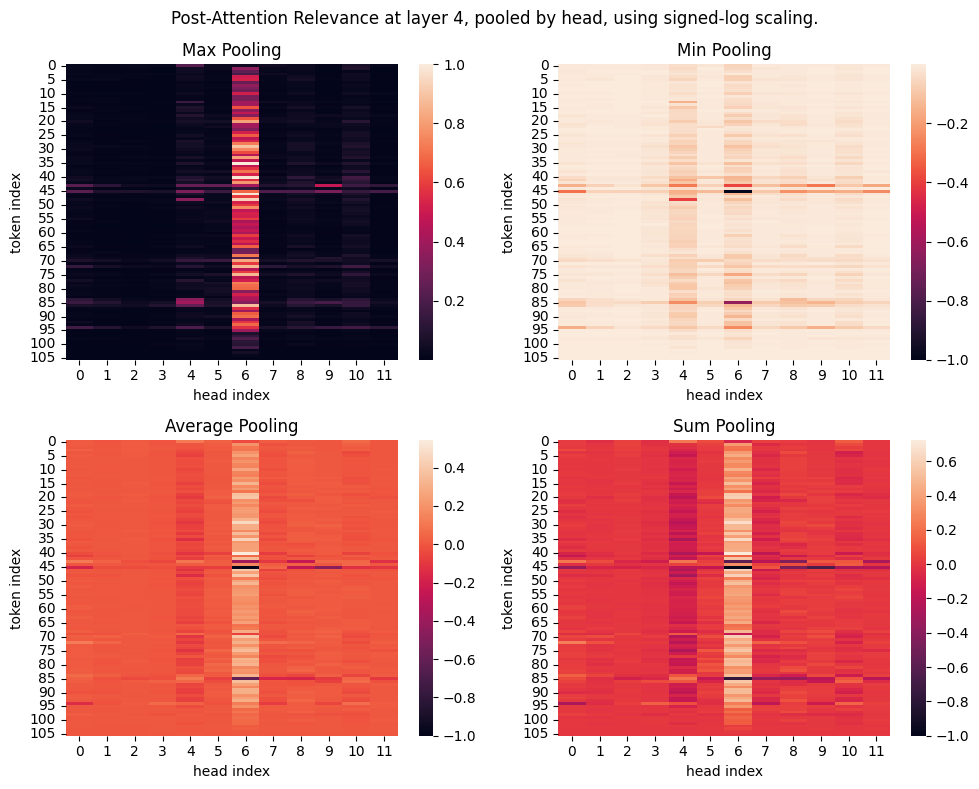

In [17]:
visualize_attention_layer_relevance(agg_checkpoint_vals, layer_ind=4)

In [18]:
peak = torch.cuda.max_memory_allocated()
print("Peak memory (bytes):", peak)

Peak memory (bytes): 1718017024
